## Imports

In [337]:
# Utils
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Spliter.
from sklearn.model_selection import train_test_split

In [338]:
# Global variables
cutsAmount = 5

## Read the data for the first time

In [339]:
cancerDataset = pd.read_csv("./cancer.csv")

cancerDataset.drop('id', axis=1, inplace=True)
cancerDataset.drop('Unnamed: 32', axis=1, inplace=True)

cancerDataset.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Malignant cancer rate    : 0.372583
Benign cancer rate       : 0.627417


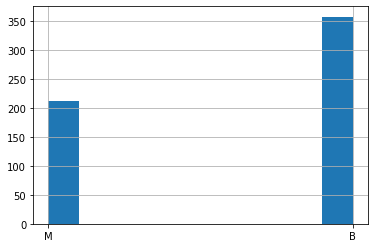

In [340]:
diagnosis = cancerDataset['diagnosis'].value_counts()
print('Malignant cancer rate    : {0:f}'.format(diagnosis['M']/len(cancerDataset)))
print('Benign cancer rate       : {0:f}'.format(diagnosis['B']/len(cancerDataset)))
cancerDataset['diagnosis'].hist()
plt.show()

## Create labels

In [341]:
Y = [int(cancerDataset['diagnosis'][i] =='B') for i in range(len(cancerDataset))]
print(Y[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


 Delete diagnosis column, we have the new labels

In [342]:
cancerDataset.drop('diagnosis', axis=1, inplace=True)
cancerDataset['classification'] = Y

## First experiment: normalize data
For the first experiment we are just going to normalize the data as feature engineering.

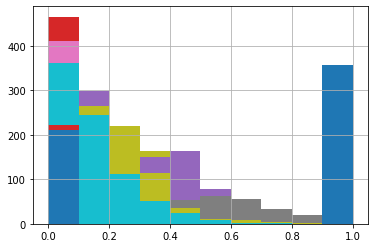

In [343]:
# Store the current labels to asign them later.
cancerDatasetLabels = cancerDataset['classification']

# Normalize the data using min max scaler.
cancerDatasetValues = cancerDataset.values
cancerDatasetNormalized = preprocessing.MinMaxScaler().fit_transform(cancerDatasetValues)
# Create a new pandas dtta frame and reasing the 'classification' column, to prevent this for be normalized.
cancerDatasetNormalized = pd.DataFrame(cancerDatasetNormalized, columns=cancerDataset.columns)
cancerDatasetNormalized['classification'] = cancerDatasetLabels

for feature in cancerDatasetNormalized.columns:
    cancerDatasetNormalized[feature].hist()

## Second experiment: standardize data
For the first experiment we are just going to standardize the data as feature engineering.

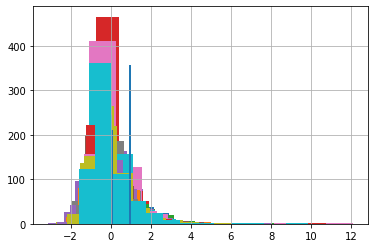

In [344]:
# Store the current labels to asign them later.
cancerDatasetLabels = cancerDataset['classification']

# Normalize the data using min max scaler.
cancerDatasetValues = cancerDataset.values
cancerDatasetStandardized = preprocessing.StandardScaler().fit_transform(cancerDatasetValues)
# Create a new pandas dtta frame and reasing the 'classification' column, to prevent this for be normalized.
cancerDatasetStandardized = pd.DataFrame(cancerDatasetStandardized, columns=cancerDataset.columns)
cancerDatasetStandardized['classification'] = cancerDatasetLabels

for feature in cancerDatasetStandardized.columns:
    cancerDatasetStandardized[feature].hist()

## Third experiment: better feature engineering
We are goin to use IQR for removing outliers in the datasets and check for missing values and duplicated
### Check missing values

In [345]:
cancerDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

Check for duplicated

In [346]:
cancerDataset.duplicated().sum()

0

Delete standard deviation columns. We are going to classify according to the mean values. 

In [347]:
#'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
#       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
#       'fractal_dimension_se'

dataSetBetterFE = cancerDataset.copy()
#The radius and perimeter are correlated according to previous VIF iteration.
# We are goind to delete this feature to prevent reduce the dateset needlessly 
dataSetBetterFE.drop('radius_mean', axis=1, inplace=True)
dataSetBetterFE.drop('perimeter_mean', axis=1, inplace=True)
#The concavity and concave points are correlated according to previous VIF iteration.
# # We are goind to delete this feature to prevent reduce the dateset needlessly  
dataSetBetterFE.drop('concave points_mean', axis=1, inplace=True)

dataSetBetterFE.drop('radius_se', axis=1, inplace=True)
dataSetBetterFE.drop('texture_se', axis=1, inplace=True)
dataSetBetterFE.drop('perimeter_se', axis=1, inplace=True)
dataSetBetterFE.drop('area_se', axis=1, inplace=True)
dataSetBetterFE.drop('smoothness_se', axis=1, inplace=True)
dataSetBetterFE.drop('compactness_se', axis=1, inplace=True)
dataSetBetterFE.drop('concavity_se', axis=1, inplace=True)
dataSetBetterFE.drop('concave points_se', axis=1, inplace=True)
dataSetBetterFE.drop('symmetry_se', axis=1, inplace=True)
dataSetBetterFE.drop('fractal_dimension_se', axis=1, inplace=True)

dataSetBetterFE.drop('radius_worst', axis=1, inplace=True)
dataSetBetterFE.drop('texture_worst', axis=1, inplace=True)
dataSetBetterFE.drop('perimeter_worst', axis=1, inplace=True)
dataSetBetterFE.drop('area_worst', axis=1, inplace=True)
dataSetBetterFE.drop('smoothness_worst', axis=1, inplace=True)
dataSetBetterFE.drop('compactness_worst', axis=1, inplace=True)
dataSetBetterFE.drop('concavity_worst', axis=1, inplace=True)
dataSetBetterFE.drop('concave points_worst', axis=1, inplace=True)
dataSetBetterFE.drop('symmetry_worst', axis=1, inplace=True)
dataSetBetterFE.drop('fractal_dimension_worst', axis=1, inplace=True)

## Delete outliers with IQR technique

In [348]:

# Describe the quantils for each features
print(dataSetBetterFE.columns)
dataSetBetterFE.describe()

Index(['texture_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'classification'],
      dtype='object')


,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,classification
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,19.289649,654.889104,0.096360,0.104341,0.088799,0.181162,0.062798,0.627417
std,4.301036,351.914129,0.014064,0.052813,0.079720,0.027414,0.007060,0.483918
min,9.710000,143.500000,0.052630,0.019380,0.000000,0.106000,0.049960,0.000000
25%,16.170000,420.300000,0.086370,0.064920,0.029560,0.161900,0.057700,0.000000
50%,18.840000,551.100000,0.095870,0.092630,0.061540,0.179200,0.061540,1.000000
75%,21.800000,782.700000,0.105300,0.130400,0.130700,0.195700,0.066120,1.000000
max,39.280000,2501.000000,0.163400,0.345400,0.426800,0.304000,0.097440,1.000000


In [349]:
def calculateBoundsWithIQR(datacolumn):
    Q1 = datacolumn.quantile(0.25)
    Q3 = datacolumn.quantile(0.75)

    IQR = Q3-Q1

    lowerRange = Q1 - (1.5 * IQR)
    higherRange = Q3 + (1.5 * IQR)

    return lowerRange, higherRange

Radius_mean

Texture_mean

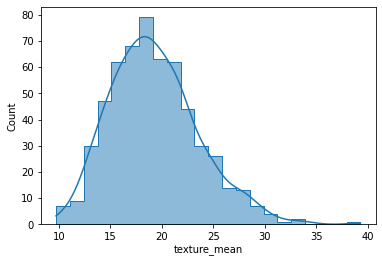

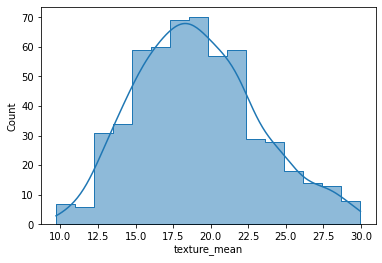

In [350]:
sns.histplot(dataSetBetterFE['texture_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['texture_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['texture_mean'] > lower) & (dataSetBetterFE['texture_mean'] < higher)]
sns.histplot(dataSetBetterFE['texture_mean'], kde=True, element='step')
plt.show()

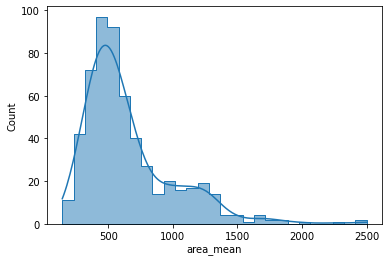

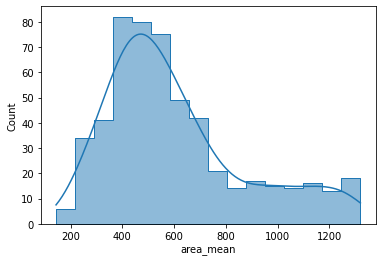

In [351]:
sns.histplot(dataSetBetterFE['area_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['area_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['area_mean'] > lower) & (dataSetBetterFE['area_mean'] < higher)]
sns.histplot(dataSetBetterFE['area_mean'], kde=True, element='step')
plt.show()

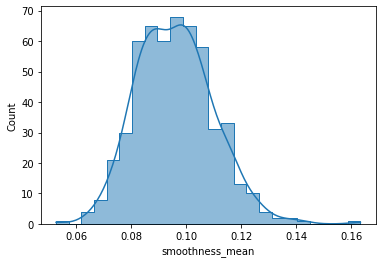

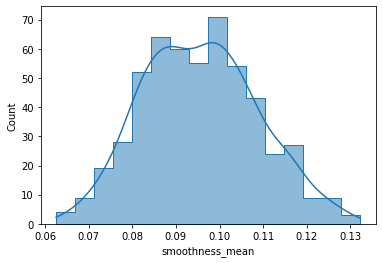

In [352]:
sns.histplot(dataSetBetterFE['smoothness_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['smoothness_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['smoothness_mean'] > lower) & (dataSetBetterFE['smoothness_mean'] < higher)]
sns.histplot(dataSetBetterFE['smoothness_mean'], kde=True, element='step')
plt.show()

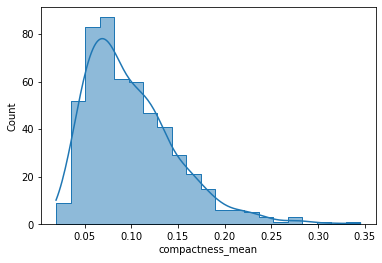

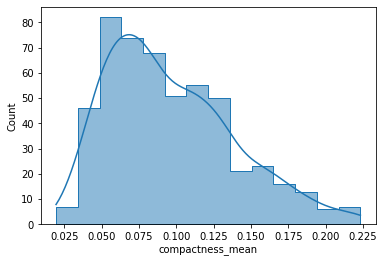

In [353]:
sns.histplot(dataSetBetterFE['compactness_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['compactness_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['compactness_mean'] > lower) & (dataSetBetterFE['compactness_mean'] < higher)]
sns.histplot(dataSetBetterFE['compactness_mean'], kde=True, element='step')
plt.show()

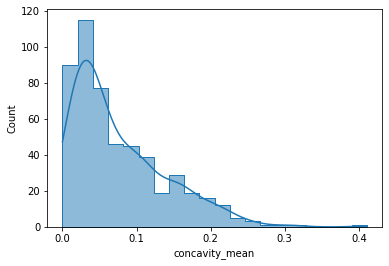

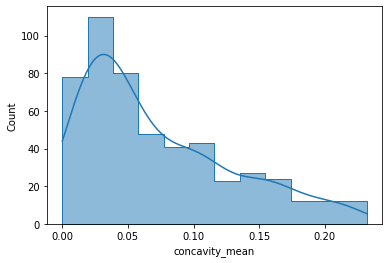

In [354]:
sns.histplot(dataSetBetterFE['concavity_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['concavity_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['concavity_mean'] > lower) & (dataSetBetterFE['concavity_mean'] < higher)]
sns.histplot(dataSetBetterFE['concavity_mean'], kde=True, element='step')
plt.show()

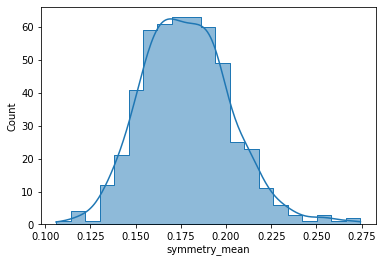

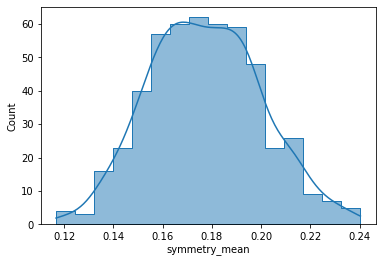

In [355]:
sns.histplot(dataSetBetterFE['symmetry_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['symmetry_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['symmetry_mean'] > lower) & (dataSetBetterFE['symmetry_mean'] < higher)]
sns.histplot(dataSetBetterFE['symmetry_mean'], kde=True, element='step')
plt.show()

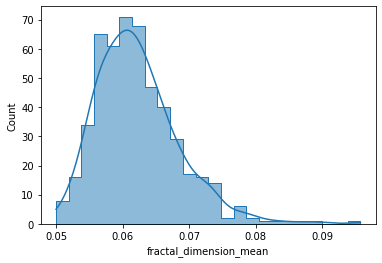

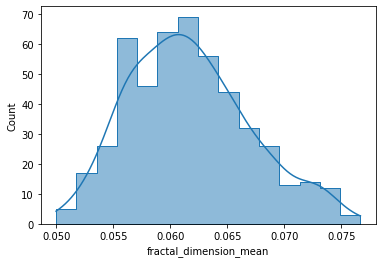

In [356]:
sns.histplot(dataSetBetterFE['fractal_dimension_mean'], kde=True, element='step')
plt.show()

lower, higher = calculateBoundsWithIQR(dataSetBetterFE['fractal_dimension_mean'])

dataSetBetterFE = dataSetBetterFE[(dataSetBetterFE['fractal_dimension_mean'] > lower) & (dataSetBetterFE['fractal_dimension_mean'] < higher)]
sns.histplot(dataSetBetterFE['fractal_dimension_mean'], kde=True, element='step')
plt.show()

In [357]:

dataSetBetterFE.shape

(489, 8)

In [358]:
# Get the columns needed to calculate the vif
variables = dataSetBetterFE[[
       'texture_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean']]
constants = add_constant(variables)

# Calculate the vif and store the values in a pandas data frame to display it.
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(constants.values, i) for i in range (constants.shape[1])]
vif['features'] = constants.columns
vif

,VIF,features
0,573.716953,const
1,1.170361,texture_mean
2,4.805626,area_mean
3,2.116809,smoothness_mean
4,7.689413,compactness_mean
5,7.196463,concavity_mean
6,1.408996,symmetry_mean
7,3.762179,fractal_dimension_mean


(489, 8)
Malignant cancer rate    : 0.321063
Benign cancer rate       : 0.678937


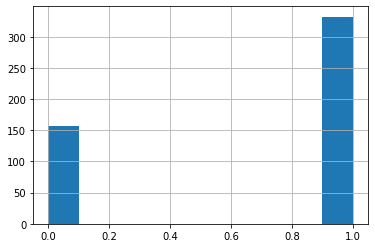

In [359]:
classification = dataSetBetterFE['classification'].value_counts()
print(dataSetBetterFE.shape)
print('Malignant cancer rate    : {0:f}'.format(classification[0]/len(dataSetBetterFE)))
print('Benign cancer rate       : {0:f}'.format(classification[1]/len(dataSetBetterFE)))
dataSetBetterFE['classification'].hist()
plt.show()

### Standardize the data

In [360]:
dataSetBetterFELabels = dataSetBetterFE['classification'].values

# Standardize the data using standar scaler.
dataSetBetterFEValues = dataSetBetterFE.values
dataSetBetterFEStandardized = preprocessing.StandardScaler().fit_transform(dataSetBetterFEValues)

# Create a new pandas data frame and reasing the 'classification' column, to prevent this for be standardized.
dataSetBetterFE = pd.DataFrame(dataSetBetterFEStandardized, columns=dataSetBetterFE.columns)
dataSetBetterFE['classification'] = dataSetBetterFELabels

In [362]:
def detailProportion(yTrain, yTest):

    print("Training set distribution")
    classification_X_train = yTrain.values

    print('Malignant cancer rate    : {0:f}%'.format(np.count_nonzero(classification_X_train == 0)  / len(yTrain)))
    print('Benign cancer rate       : {0:f}%'.format(np.count_nonzero(classification_X_train == 1)  / len(yTrain)))
    print('Training set size ', len(yTrain))
    print('Training set rate {0:f}%'.format(len(yTrain)/(len(yTrain)+len(yTest))))

    print('---------------------')
    print("Test set distribution")
    classification_X_test = yTest.values
    print('Malignant cancer rate    : {0:f}%'.format(np.count_nonzero(classification_X_test == 0) / len(yTest)))
    print('Benign cancer rate       : {0:f}%'.format(np.count_nonzero(classification_X_test == 1) / len(yTest)))
    print('Test set size: ', len(yTest))
    print('Training set rate: {0:f}%'.format(len(yTest)/(len(yTrain)+len(yTest))))
    print()

In [364]:
def getDatasetCut(dataset, classColumnName):
    # Declare the target variable.
    y = dataset[classColumnName].values
    # Declare independent variables.
    x = dataset.drop([classColumnName], axis=1).values

    # Get the train and the test values.
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8, stratify=y, shuffle=True)

    # Return the values.
    return xTrain, xTest, yTrain, yTest

def saveCSV(dataFrame, dir, filename):
    Path(os.path.join(os.getcwd(), dir)).mkdir(parents=True, exist_ok=True)

    dataFrame.to_csv(os.path.join(os.getcwd(), dir, filename), header=True,  index = False)
    #with open(os.path.join(os.getcwd(), dir, filename), 'a') as file:
        #file.write(dataFrame.to_csv())

def storeDatasetCut(dataset, classColumnName, dir, detail):
    # Get the cut.
    xTrain, xTest, yTrain, yTest = getDatasetCut(dataset, classColumnName)

    # Create a pandas data frame and store every partition.
    xTrain = pd.DataFrame(xTrain, columns=dataset.columns[:-1])
    xTest = pd.DataFrame(xTest, columns=dataset.columns[:-1])
    yTrain = pd.DataFrame(yTrain, columns=[dataset.columns[-1:]])
    yTest = pd.DataFrame(yTest, columns=[dataset.columns[-1:]])

    if detail:
        detailProportion(yTrain, yTest)

    # Save the coso in csv format.
    saveCSV(xTrain, dir, 'xTrain.csv')
    saveCSV(xTest, dir, 'xTest.csv')
    saveCSV(yTrain, dir, 'yTrain.csv')
    saveCSV(yTest, dir, 'yTest.csv')

# Crear cinco cortes para cada una de las pruebas.
for i in range(1, cutsAmount + 1):
    #print('Normalized\\cut{}\\'.format(i))
    storeDatasetCut(cancerDatasetNormalized, 'classification', '_Normalized\\cut{}\\'.format(i), i == 1)

for i in range(1, cutsAmount + 1):
    #print('Standardized\\cut{}\\'.format(i))
    storeDatasetCut(cancerDatasetStandardized, 'classification', '_Standardized\\cut{}\\'.format(i), i == 1)

for i in range(1, cutsAmount + 1):
    #print('BetterFE\\cut{}\\'.format(i))
    storeDatasetCut(dataSetBetterFE, 'classification', '_BetterFE\\cut{}\\'.format(i), i == 1)

Training set distribution
Malignant cancer rate    : 0.373626%
Benign cancer rate       : 0.626374%
Training set size  455
Training set rate 0.799649%
---------------------
Test set distribution
Malignant cancer rate    : 0.368421%
Benign cancer rate       : 0.631579%
Test set size:  114
Training set rate: 0.200351%

Training set distribution
Malignant cancer rate    : 0.373626%
Benign cancer rate       : 0.626374%
Training set size  455
Training set rate 0.799649%
---------------------
Test set distribution
Malignant cancer rate    : 0.368421%
Benign cancer rate       : 0.631579%
Test set size:  114
Training set rate: 0.200351%

Training set distribution
Malignant cancer rate    : 0.322251%
Benign cancer rate       : 0.677749%
Training set size  391
Training set rate 0.799591%
---------------------
Test set distribution
Malignant cancer rate    : 0.316327%
Benign cancer rate       : 0.683673%
Test set size:  98
Training set rate: 0.200409%

